In [1]:
#include <iostream>
#include <stdio.h>
#include <string>
#include <vector>

In [2]:
TFile *file = TFile::Open("../Data_8TeV.root");
TTree *tree = (TTree*) file->Get("mini");
tree->Print();

******************************************************************************
*Tree    :mini      : 4-vectors + variables required for scaling factors     *
*Entries : 14945674 : Total =      3737586466 bytes  File  Size = 1366006484 *
*        :          : Tree compression factor =   2.74                       *
******************************************************************************
*Br    0 :runNumber : runNumber/I                                            *
*Entries : 14945674 : Total  Size=   59789737 bytes  File Size  =     297928 *
*Baskets :       70 : Basket Size=    1224192 bytes  Compression= 200.68     *
*............................................................................*
*Br    1 :eventNumber : eventNumber/I                                        *
*Entries : 14945674 : Total  Size=   59789885 bytes  File Size  =   44412272 *
*Baskets :       70 : Basket Size=    1224192 bytes  Compression=   1.35     *
*...................................................

In [3]:
//create leading jet pt and all jets histograms
TH1F *cutflow = new TH1F("Cutflow","Cutflow; Cut; Events",10,0,10);
TH1F *hist_njets_data = new TH1F("Number of jets","n-jets; Jet multiplicity; Events",6,4,10);
//TH1F *aux = new TH1F("Number of good leptons","n-leptons; n-leptons; Events",10,0,10);

//create canvas
TCanvas *canvas = new TCanvas("Canvas","",800,600);

In [4]:
// activate variables to use

//scalar variables
Bool_t e_trig;
Bool_t mu_trig;
Bool_t good_vtx;
UInt_t lep_n;
UInt_t jet_n;
Float_t MET;
Float_t MET_phi;

// vectorial or array variables
Float_t lep_pt[10];
Float_t lep_eta[10];
Float_t lep_phi[10];
Float_t lep_E[10];
Float_t lep_ptcone30[10];
Float_t lep_etcone20[10];
Int_t lep_type[10];

Float_t jet_pt[10];
Float_t jet_eta[10];
Float_t jet_jvf[10];
Float_t jet_MV1[10];

// assign address of data to variables
tree->SetBranchAddress("trigE", &e_trig);
tree->SetBranchAddress("trigM", &mu_trig);
tree->SetBranchAddress("hasGoodVertex", &good_vtx);
tree->SetBranchAddress("lep_n", &lep_n);
tree->SetBranchAddress("jet_n", &jet_n);
tree->SetBranchAddress("met_et", &MET);
tree->SetBranchAddress("met_phi", &MET_phi);

tree->SetBranchAddress("lep_pt", &lep_pt);
tree->SetBranchAddress("lep_eta", &lep_eta);
tree->SetBranchAddress("lep_phi", &lep_phi);
tree->SetBranchAddress("lep_E", &lep_E);
tree->SetBranchAddress("lep_type", &lep_type);
tree->SetBranchAddress("lep_ptcone30", &lep_ptcone30);
tree->SetBranchAddress("lep_etcone20", &lep_etcone20);

tree->SetBranchAddress("jet_pt", &jet_pt);
tree->SetBranchAddress("jet_eta", &jet_eta);
tree->SetBranchAddress("jet_jvf", &jet_jvf);
tree->SetBranchAddress("jet_MV1", &jet_MV1);

In [5]:
//loop and fill the histograms
int nentries, nbytes, i;
nentries = (Int_t)tree->GetEntries();

int cut1 = 0;
int cut2 = 0;
int cut3 = 0;
int cut4 = 0;
int cut5 = 0;
int cut6 = 0;
int cut7 = 0;
int cut8 = 0;



for (i = 0; i < nentries; i++) {
    nbytes = tree->GetEntry(i);
    vector <int> index;

    //First cut: Good vertex
    if (!good_vtx) continue;
    cut1++;
    cutflow->Fill(1);

    //Second cut: Trigger
    if (!e_trig && !mu_trig) continue;
    cut2++;
    cutflow->Fill(2);

    //Preselection of good leptons
    int n_mu = 0; //number of good muons
    int n_el = 0; //number of good electrons
    int n_lep = 0; //number of good leptons


    //Loop over leptons
    for (unsigned i = 0; i < lep_n; i++) {
        if (lep_pt[i] < 25000.0) continue;
        if (lep_ptcone30[i]/lep_pt[i] > 0.15) continue;
        if (lep_etcone20[i]/lep_pt[i] > 0.15) continue;
        if (lep_type[i] == 13 && TMath::Abs(lep_eta[i]) < 2.5) {
            n_mu++;
        }
        //To complete: Add electrons and extract the index for the good lepton
        float center = (1.52+1.37)/2;
        float width = (1.52-1.37)/2;
        if (lep_type[i] == 11 && TMath::Abs(lep_eta[i]) < 2.47 ) {
        if (TMath::Abs(TMath::Abs(lep_eta[i]) - center) > width) {
          n_el++;
        }
      }
      index.push_back(i);
      n_lep++;
    }

    /*std::cout << index.size() << std::endl;
    aux->Fill(index.size());*/

    //Select events with only 1 good lepton and fill the cutflow histogram
    //Third cut (one good lepton):
    if (n_lep != 1) continue;
    cutflow->Fill(3);
    cut3++;


    int n_jets = 0;
    int n_bjets = 0;

    
    //Fourth cut: At least 4 jets
    if (jet_n < 4) continue;
    cutflow->Fill(4);
    cut4++;

    for (unsigned j = 0; j < jet_n; j++) {
        // To complete: apply jet cuts to find the good jets
        if (jet_pt[j] < 25000.) continue;
        if (TMath::Abs(jet_eta[j]) > 2.5) continue; //Eta cut
        //JVF cut
        if (jet_pt[j] < 50000. && TMath::Abs(jet_eta[j]) < 2.4 && TMath::Abs(jet_jvf[j]) > 0.5) {
            n_jets++;
        }
        if (jet_pt[j] > 50000. && TMath::Abs(jet_jvf[j]) > 0.5) {
            n_jets++;
        }
        if (jet_MV1[j] < 0.7892) continue; //cut on 0.7892 MV1 and count the number of b-jets
            n_bjets++;
    }

    //Fifth cut: At least 4 good jets
    if (n_jets < 4) continue;
    cutflow->Fill(5);
    cut5++;

    //Sixth cut: at least two b-jet
    if (n_bjets < 2) continue;
    cutflow->Fill(6);
    cut6++;

    //Seventh cut: MET > 30 GeV
    if (MET < 30000.) continue;
    cutflow->Fill(7);
    cut7++;

    //TLorentzVector definitions
    TLorentzVector Lepton = TLorentzVector();
    TLorentzVector MeT = TLorentzVector();

    //To complete: Lorentz vectors for the lepton and MET. Use SetPtEtaPhiE().
    Lepton.SetPtEtaPhiE(lep_pt[index[0]],lep_eta[index[0]],lep_phi[index[0]],lep_E[index[0]]);
    MeT.SetPtEtaPhiE(0,0,MET_phi,MET);

    //Calculation of the mTW using TLorenzt vectors
    float mTW = sqrt(2*Lepton.Pt()*MeT.E()*(1-cos(Lepton.DeltaPhi(MeT))));

    //Eight cut: mTW > 30 GeV
    if (mTW < 30000.) continue;
    cutflow->Fill(8);
    cut8++;



    index.clear();
    
    
    //Number of jets distribution
    hist_njets_data->Fill(jet_n);
    
}

std::cout << "Done!" << std::endl;
std::cout << "All events:" << "\t" << nentries << std::endl;
std::cout << "Cut1:" << "\t" << cut1 << std::endl;
std::cout << "Cut2:" << "\t" << cut2 << std::endl;
std::cout << "Cut3:" << "\t" << cut3 << std::endl;
std::cout << "Cut4:" << "\t" << cut4 << std::endl;
std::cout << "Cut5:" << "\t" << cut5 << std::endl;
std::cout << "Cut6:" << "\t" << cut6 << std::endl;
std::cout << "Cut7:" << "\t" << cut7 << std::endl;
std::cout << "Cut8:" << "\t" << cut8 << std::endl;

Done!
All events:	1030764205
Cut1:	1030474971
Cut2:	1030474971
Cut3:	1027380332
Cut4:	61995
Cut5:	58149
Cut6:	10525
Cut7:	8351
Cut8:	6921


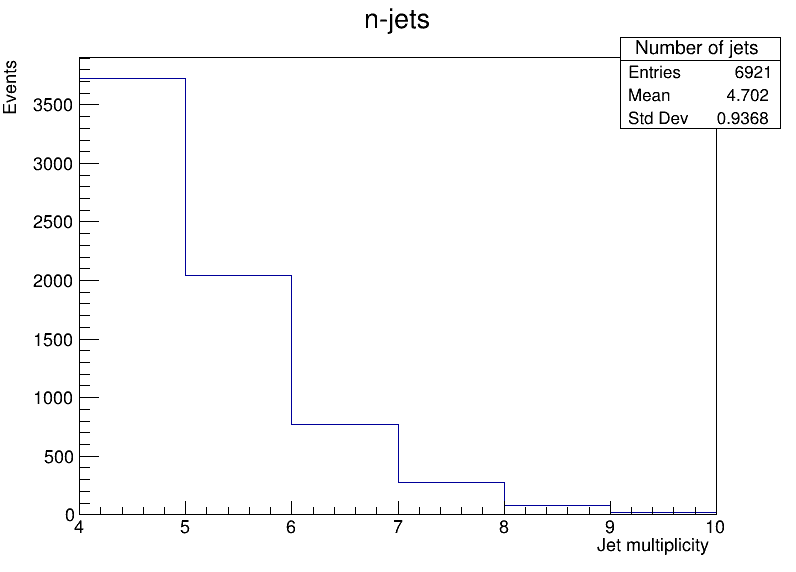

In [6]:
hist_njets_data->Draw();
canvas->Draw(); 

In [7]:
TFile *file = TFile::Open("../ttbar_8TeV.root");
TTree *tree = (TTree*) file->Get("mini");
tree->Print();

******************************************************************************
*Tree    :mini      : 4-vectors + variables required for scaling factors     *
*Entries :  1500000 : Total =       567791759 bytes  File  Size =  300057248 *
*        :          : Tree compression factor =   1.89                       *
******************************************************************************
*Br    0 :runNumber : runNumber/I                                            *
*Entries :  1500000 : Total  Size=    6002049 bytes  File Size  =      31136 *
*Baskets :       18 : Basket Size=     790016 bytes  Compression= 192.75     *
*............................................................................*
*Br    1 :eventNumber : eventNumber/I                                        *
*Entries :  1500000 : Total  Size=    6002093 bytes  File Size  =    3819950 *
*Baskets :       18 : Basket Size=     790016 bytes  Compression=   1.57     *
*...................................................

In [8]:
//create leading jet pt and all jets histograms
TH1F *cutflow = new TH1F("Cutflow","Cutflow; Cut; Events",10,0,10);
TH1F *hist_njets_mc = new TH1F("Number of jets","n-jets; Jet multiplicity; Events",6,4,10);
//TH1F *aux = new TH1F("Number of good leptons","n-leptons; n-leptons; Events",10,0,10);

//create canvas
TCanvas *canvas = new TCanvas("Canvas","",800,600);

Warning in <TCanvas::Constructor>: Deleting canvas with same name: Canvas


In [9]:
// activate variables to use

//scalar variables
Bool_t e_trig;
Bool_t mu_trig;
Bool_t good_vtx;
UInt_t lep_n;
UInt_t jet_n;
Float_t MET;
Float_t MET_phi;

// vectorial or array variables
Float_t lep_pt[10];
Float_t lep_eta[10];
Float_t lep_phi[10];
Float_t lep_E[10];
Float_t lep_ptcone30[10];
Float_t lep_etcone20[10];
Int_t lep_type[10];

Float_t jet_pt[10];
Float_t jet_eta[10];
Float_t jet_jvf[10];
Float_t jet_MV1[10];

//scale factors
Float_t scaleFactor_PILEUP;

// assign address of data to variables
tree->SetBranchAddress("trigE", &e_trig);
tree->SetBranchAddress("trigM", &mu_trig);
tree->SetBranchAddress("hasGoodVertex", &good_vtx);
tree->SetBranchAddress("lep_n", &lep_n);
tree->SetBranchAddress("jet_n", &jet_n);
tree->SetBranchAddress("met_et", &MET);
tree->SetBranchAddress("met_phi", &MET_phi);

tree->SetBranchAddress("lep_pt", &lep_pt);
tree->SetBranchAddress("lep_eta", &lep_eta);
tree->SetBranchAddress("lep_phi", &lep_phi);
tree->SetBranchAddress("lep_E", &lep_E);
tree->SetBranchAddress("lep_type", &lep_type);
tree->SetBranchAddress("lep_ptcone30", &lep_ptcone30);
tree->SetBranchAddress("lep_etcone20", &lep_etcone20);

tree->SetBranchAddress("jet_pt", &jet_pt);
tree->SetBranchAddress("jet_eta", &jet_eta);
tree->SetBranchAddress("jet_jvf", &jet_jvf);
tree->SetBranchAddress("jet_MV1", &jet_MV1);

tree->SetBranchAddress("scaleFactor_PILEUP", &scaleFactor_PILEUP);

In [10]:
//loop and fill the histograms
int nentries, nbytes, i;
nentries = (Int_t)tree->GetEntries();

int cut1 = 0;
int cut2 = 0;
int cut3 = 0;
int cut4 = 0;
int cut5 = 0;
int cut6 = 0;
int cut7 = 0;
int cut8 = 0;



for (i = 0; i < nentries; i++) {
    nbytes = tree->GetEntry(i);
    vector <int> index;

    //First cut: Good vertex
    if (!good_vtx) continue;
    cut1++;
    cutflow->Fill(1);

    //Second cut: Trigger
    if (!e_trig && !mu_trig) continue;
    cut2++;
    cutflow->Fill(2);

    //Preselection of good leptons
    int n_mu = 0; //number of good muons
    int n_el = 0; //number of good electrons
    int n_lep = 0; //number of good leptons


    //Loop over leptons
    for (unsigned i = 0; i < lep_n; i++) {
        if (lep_pt[i] < 25000.0) continue;
        if (lep_ptcone30[i]/lep_pt[i] > 0.15) continue;
        if (lep_etcone20[i]/lep_pt[i] > 0.15) continue;
        if (lep_type[i] == 13 && TMath::Abs(lep_eta[i]) < 2.5) {
            n_mu++;
        }
        //To complete: Add electrons and extract the index for the good lepton
        float center = (1.52+1.37)/2;
        float width = (1.52-1.37)/2;
        if (lep_type[i] == 11 && TMath::Abs(lep_eta[i]) < 2.47 ) {
        if (TMath::Abs(TMath::Abs(lep_eta[i]) - center) > width) {
          n_el++;
        }
      }
      index.push_back(i);
      n_lep++;
    }

    /*std::cout << index.size() << std::endl;
    aux->Fill(index.size());*/

    //Select events with only 1 good lepton and fill the cutflow histogram
    //Third cut (one good lepton):
    if (n_lep != 1) continue;
    cutflow->Fill(3);
    cut3++;


    int n_jets = 0;
    int n_bjets = 0;

    //Number of jets distribution
    //hist_njets_mc->Fill(jet_n);

    
    //Fourth cut: At least 4 jets
    if (jet_n < 4) continue;
    cutflow->Fill(4);
    cut4++;

    for (unsigned j = 0; j < jet_n; j++) {
        // To complete: apply jet cuts to find the good jets
        if (jet_pt[j] < 25000.) continue;
        if (TMath::Abs(jet_eta[j]) > 2.5) continue; //Eta cut
        //JVF cut
        if (jet_pt[j] < 50000. && TMath::Abs(jet_eta[j]) < 2.4 && TMath::Abs(jet_jvf[j]) > 0.5) {
            n_jets++;
        }
        if (jet_pt[j] > 50000. && TMath::Abs(jet_jvf[j]) > 0.5) {
            n_jets++;
        }
        if (jet_MV1[j] < 0.7892) continue; //cut on 0.7892 MV1 and count the number of b-jets
            n_bjets++;
    }

    //Fifth cut: At least 4 good jets
    if (n_jets < 4) continue;
    cutflow->Fill(5);
    cut5++;

    //Sixth cut: at least two b-jet
    if (n_bjets < 2) continue;
    cutflow->Fill(6);
    cut6++;

    //Seventh cut: MET > 30 GeV
    if (MET < 30000.) continue;
    cutflow->Fill(7);
    cut7++;

    //TLorentzVector definitions
    TLorentzVector Lepton = TLorentzVector();
    TLorentzVector MeT = TLorentzVector();

    //To complete: Lorentz vectors for the lepton and MET. Use SetPtEtaPhiE().
    Lepton.SetPtEtaPhiE(lep_pt[index[0]],lep_eta[index[0]],lep_phi[index[0]],lep_E[index[0]]);
    MeT.SetPtEtaPhiE(0,0,MET_phi,MET);

    //Calculation of the mTW using TLorenzt vectors
    float mTW = sqrt(2*Lepton.Pt()*MeT.E()*(1-cos(Lepton.DeltaPhi(MeT))));

    //Eight cut: mTW > 30 GeV
    if (mTW < 30000.) continue;
    cutflow->Fill(8);
    cut8++;



    index.clear();
    
    //Number of jets distribution
    //Float_t evtw = ;
    hist_njets_mc->Fill(jet_n);
    
}

std::cout << "Done!" << std::endl;
std::cout << "All events:" << "\t" << nentries << std::endl;
std::cout << "Cut1:" << "\t" << cut1 << std::endl;
std::cout << "Cut2:" << "\t" << cut2 << std::endl;
std::cout << "Cut3:" << "\t" << cut3 << std::endl;
std::cout << "Cut4:" << "\t" << cut4 << std::endl;
std::cout << "Cut5:" << "\t" << cut5 << std::endl;
std::cout << "Cut6:" << "\t" << cut6 << std::endl;
std::cout << "Cut7:" << "\t" << cut7 << std::endl;
std::cout << "Cut8:" << "\t" << cut8 << std::endl;

Done!
All events:	1061140381
Cut1:	1061139868
Cut2:	1061139868
Cut3:	1060979670
Cut4:	1060265231
Cut5:	1060243643
Cut6:	254095
Cut7:	209720
Cut8:	173654


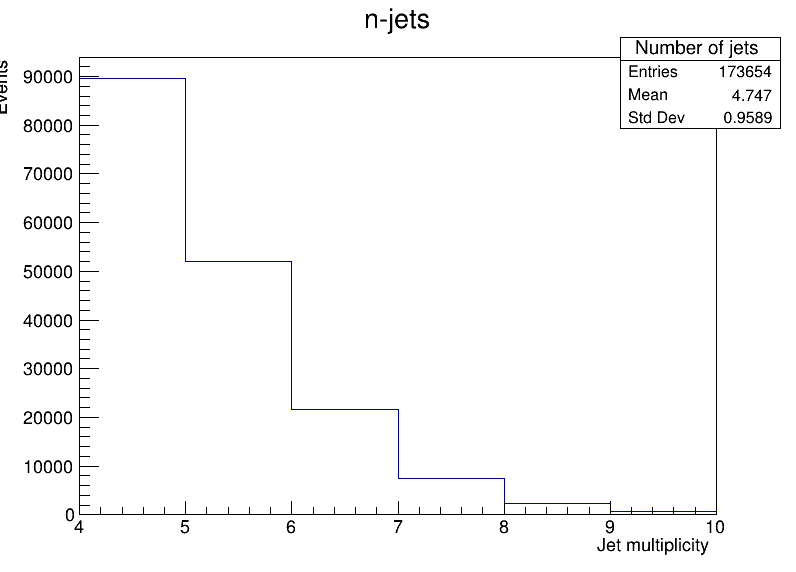

In [11]:
hist_njets_mc->Draw();
canvas->Draw(); 

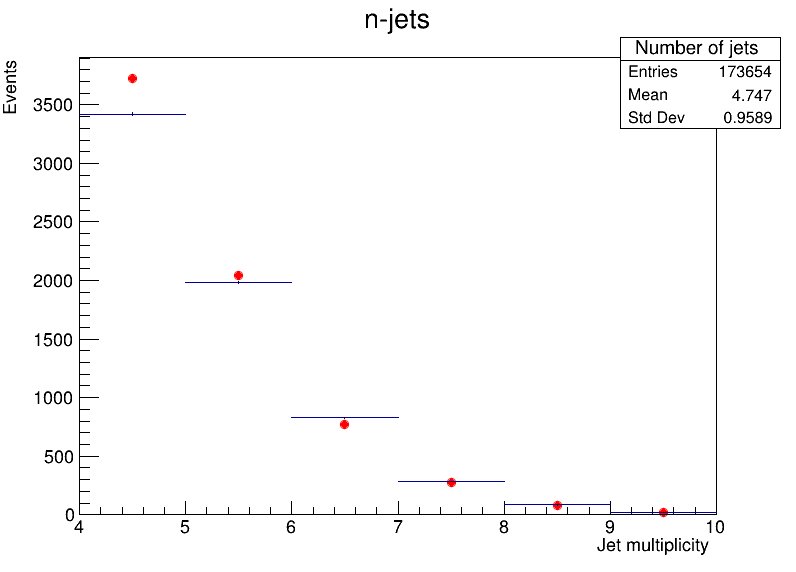

In [13]:
hist_njets_data->SetMarkerStyle(20);
hist_njets_data->SetMarkerColor(kRed);
hist_njets_data->Draw("p");
//hist_njets_mc->SetMarkerStyle(21);
//hist_njets_mc->SetMarkerColor(kBlue);
hist_njets_mc->Scale((1000.*137.29749)/(49761200.21*0.072212854)); // re-scale MC histogram
hist_njets_mc->Draw("same");
canvas->Draw();